In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size.
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with a 50% chance.
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees.
    transforms.RandomCrop(size=(128, 128), padding=4),  # Randomly crop images with optional padding.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply random affine transformations (translation in this case).
    transforms.ToTensor(),  # Convert the PIL image to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor with mean and std from ImageNet.
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
train_images = datasets.ImageFolder(
    root="/kaggle/input/covid19-image-dataset/Covid19-dataset/train",
    transform=train_transform,
)
test_images = datasets.ImageFolder(
    root="/kaggle/input/covid19-image-dataset/Covid19-dataset/test", 
    transform=test_transform,
)

In [4]:
print(f"Train data:\n{train_images}\nTest data:\n{test_images}")

Train data:
Dataset ImageFolder
    Number of datapoints: 251
    Root location: /kaggle/input/covid19-image-dataset/Covid19-dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomCrop(size=(128, 128), padding=4)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 66
    Root location: /kaggle/input/covid19-image-dataset/Covid19-dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456

In [5]:
def plot_images(dataset, title, num_images=6):
    # Get a random set of images and labels
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    # Create a grid of images
    grid_img = make_grid(images, nrow=num_images, padding=2).permute(1, 2, 0)
    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

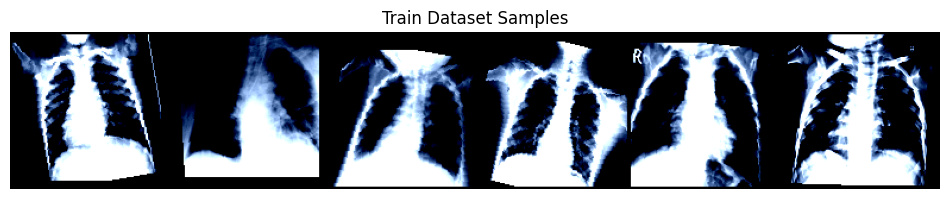

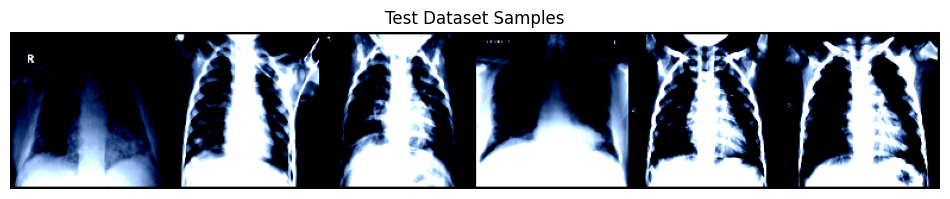

In [6]:
plot_images(train_images, "Train Dataset Samples")
plot_images(test_images, "Test Dataset Samples")

In [7]:
len(train_images), len(test_images)

(251, 66)

In [8]:
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 32  # Number of samples per batch
num_workers = 4  # Number of worker threads for data loading

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
NUM_CLASSES = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MobileNetV2Transfer(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Transfer, self).__init__()
        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Freeze the base model
        for param in mobilenet.parameters():
            param.requires_grad = True
        
        # Remove the original classifier
        features = list(mobilenet.features)
        
        # Custom classifier
        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),  # Global Max Pooling equivalent
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x): 
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = MobileNetV2Transfer(NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 145MB/s]


In [10]:
model = model = MobileNetV2Transfer((NUM_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = (correct_preds / total_preds) * 100

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/10, Loss: 0.7674, Accuracy: 61.75%
Epoch 2/10, Loss: 0.4436, Accuracy: 82.07%
Epoch 3/10, Loss: 0.3020, Accuracy: 91.24%
Epoch 4/10, Loss: 0.3605, Accuracy: 87.25%
Epoch 5/10, Loss: 0.2344, Accuracy: 89.64%
Epoch 6/10, Loss: 0.2090, Accuracy: 93.63%
Epoch 7/10, Loss: 0.2815, Accuracy: 91.24%
Epoch 8/10, Loss: 0.1055, Accuracy: 98.01%
Epoch 9/10, Loss: 0.0787, Accuracy: 98.01%
Epoch 10/10, Loss: 0.1482, Accuracy: 96.02%


In [12]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to calculate loss and accuracy on test data
test_loss = 0.0
correct_preds = 0
total_preds = 0

# No gradient tracking during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        
        # Accumulate the loss
        test_loss += loss.item()

# Calculate average loss and accuracy for test data
avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct_preds / total_preds) * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0725, Test Accuracy: 95.45%
